- Test the robustness of findings under different high-risk group sizes: s_H=10^{-2,-1,1}; half-life=2 day; network of 10^5 nodes
- Reproduce Fig.4 in the paper 

In [12]:
import pandas as pd
import seaborn as sns

# Prevalence: Read data

In [13]:
exp_type = "vary_illegal_probability_scatter"
data = pd.read_parquet(f"data/{exp_type}.parquet")

In [14]:
data.head()

,unique_illegal_frac,illegal_prob,is_base,base_name
0,0.001216,0.0009,True,b_0.0009__diff_true.json.gz
1,0.001807,0.0020,True,b_0.002__diff_true.json.gz
2,0.009838,0.0100,True,b_0.01__diff_true.json.gz
3,0.000155,0.0001,True,b_0.0001__diff_true.json.gz
4,0.000990,0.0010,True,b_0.001__diff_true.json.gz


## Baseline

In [16]:
baseline = data[data.is_base==True]

In [17]:
# assign an index to baseline exp name, so we can match it with a non-baseline exp
# Create the new column with name and index using groupby and cumcount
# e.g: if there are 3 files with the same config, basename= b_0.001__diff_true, the new column indexed_basename will be b_0.001__diff_true_0, b_0.001__diff_true_1, b_0.001__diff_true_2
baseline["indexed_basename"] = (
    baseline.groupby("base_name").cumcount().apply(lambda x: f"_{x}")
)

# Concatenate the original 'name' column with the new suffix
baseline["indexed_basename"] = baseline["base_name"] + baseline["indexed_basename"]

# baseline.indexed_basename

<ipython-input-17-adff304025a5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline["indexed_basename"] = (
<ipython-input-17-adff304025a5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline["indexed_basename"] = baseline["base_name"] + baseline["indexed_basename"]


## Non-baseline

In [18]:
print("Filtering non-baseline results...")

res = data[data.is_base ==False]


# Note that the last index of the network config matches that of the exp config (e.g: we want to run illegal_prob = illegal_spreader_frac=0.01)
# e.g: 50__diff_false has the baseline of b0__diff_false
# b_0.01__diff_true
def get_base_name(string):
    return "b" + string[1:]


# merge mod=True with baseline (mod=False) so that each record has 2 cols: metric_baseline and metric
# We then use these 2 cols to calculate relative metrics
res["baseline_name"] = res["base_name"].apply(lambda x: get_base_name(x))

## Index name for non-baseline exp
# Create the new column with name and index using groupby and cumcount
res["indexed_basename"] = (
    res.groupby("baseline_name").cumcount().apply(lambda x: f"_{x}")
)

# Concatenate the original 'name' column with the new suffix
res["indexed_basename"] = res["baseline_name"] + res["indexed_basename"]

Filtering non-baseline results...


<ipython-input-18-283138fa523a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["baseline_name"] = res["base_name"].apply(lambda x: get_base_name(x))
<ipython-input-18-283138fa523a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["indexed_basename"] = (
<ipython-input-18-283138fa523a>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [19]:
res.head()

,unique_illegal_frac,illegal_prob,is_base,base_name,baseline_name,indexed_basename
5,0.003506,0.0090,False,1_0.009__diff_true.json.gz,b_0.009__diff_true.json.gz,b_0.009__diff_true.json.gz_0
6,0.000077,0.0001,False,1_0.0001__diff_true.json.gz,b_0.0001__diff_true.json.gz,b_0.0001__diff_true.json.gz_0
7,0.003814,0.0100,False,1_0.01__diff_true.json.gz,b_0.01__diff_true.json.gz,b_0.01__diff_true.json.gz_0
10,0.000104,0.0003,False,1_0.0003__diff_true.json.gz,b_0.0003__diff_true.json.gz,b_0.0003__diff_true.json.gz_0
15,0.000542,0.0020,False,1_0.002__diff_true.json.gz,b_0.002__diff_true.json.gz,b_0.002__diff_true.json.gz_0


In [20]:
res.indexed_basename.unique()

array(['b_0.009__diff_true.json.gz_0', 'b_0.0001__diff_true.json.gz_0',
       'b_0.01__diff_true.json.gz_0', 'b_0.0003__diff_true.json.gz_0',
       'b_0.002__diff_true.json.gz_0', 'b_0.009__diff_true.json.gz_1',
       'b_0.001__diff_true.json.gz_0', 'b_0.01__diff_true.json.gz_1',
       'b_0.0009__diff_true.json.gz_0', 'b_0.002__diff_true.json.gz_1',
       'b_0.009__diff_true.json.gz_2', 'b_0.001__diff_true.json.gz_1',
       'b_0.01__diff_true.json.gz_2', 'b_0.0009__diff_true.json.gz_1',
       'b_0.002__diff_true.json.gz_2', 'b_0.009__diff_true.json.gz_3',
       'b_0.01__diff_true.json.gz_3', 'b_0.0009__diff_true.json.gz_2',
       'b_0.0003__diff_true.json.gz_1', 'b_0.009__diff_true.json.gz_4',
       'b_0.001__diff_true.json.gz_2', 'b_0.01__diff_true.json.gz_4',
       'b_0.0009__diff_true.json.gz_3', 'b_0.002__diff_true.json.gz_3',
       'b_0.009__diff_true.json.gz_5', 'b_0.01__diff_true.json.gz_5',
       'b_0.0009__diff_true.json.gz_4', 'b_0.002__diff_true.json.gz_4',
    

## Data frame of removal-no removal pairs for scatter plot

In [21]:
metric = "unique_illegal_frac"

baseline = baseline.rename(columns={f"{metric}": f"baseline_{metric}"})
focal_scatter = pd.merge(
    baseline[["indexed_basename", "base_name", f"baseline_{metric}"]],
    res[
        [
            "illegal_prob",
            "indexed_basename",
            metric,
        ]
    ],
    on="indexed_basename",
    how="left",
)
focal_scatter.head()

,indexed_basename,base_name,baseline_unique_illegal_frac,illegal_prob,unique_illegal_frac
0,b_0.0009__diff_true.json.gz_0,b_0.0009__diff_true.json.gz,0.001216,0.0009,0.000305
1,b_0.002__diff_true.json.gz_0,b_0.002__diff_true.json.gz,0.001807,0.0020,0.000542
2,b_0.01__diff_true.json.gz_0,b_0.01__diff_true.json.gz,0.009838,0.0100,0.003814
3,b_0.0001__diff_true.json.gz_0,b_0.0001__diff_true.json.gz,0.000155,0.0001,0.000077
4,b_0.001__diff_true.json.gz_0,b_0.001__diff_true.json.gz,0.000990,0.0010,0.000333


In [22]:
focal_scatter.base_name.unique()

array(['b_0.0009__diff_true.json.gz', 'b_0.002__diff_true.json.gz',
       'b_0.01__diff_true.json.gz', 'b_0.0001__diff_true.json.gz',
       'b_0.001__diff_true.json.gz', 'b_0.009__diff_true.json.gz',
       'b_0.0003__diff_true.json.gz'], dtype=object)

In [23]:
focal_scatter.shape

(250, 5)

In [24]:
focal_scatter.head()

,indexed_basename,base_name,baseline_unique_illegal_frac,illegal_prob,unique_illegal_frac
0,b_0.0009__diff_true.json.gz_0,b_0.0009__diff_true.json.gz,0.001216,0.0009,0.000305
1,b_0.002__diff_true.json.gz_0,b_0.002__diff_true.json.gz,0.001807,0.0020,0.000542
2,b_0.01__diff_true.json.gz_0,b_0.01__diff_true.json.gz,0.009838,0.0100,0.003814
3,b_0.0001__diff_true.json.gz_0,b_0.0001__diff_true.json.gz,0.000155,0.0001,0.000077
4,b_0.001__diff_true.json.gz_0,b_0.001__diff_true.json.gz,0.000990,0.0010,0.000333


In [25]:
focal_scatter = focal_scatter.dropna()

## Scatter with regression line

Slope: 0.95
R-squared: 0.96
p-val: 0.00
std_err: 0.01
MSE: 1.28e-02


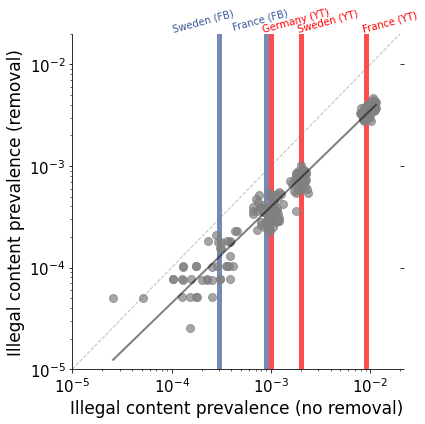

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error

plt.style.use("stylesheet_scatter.mplstyle")

PLOT_DIR = "plots"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

fpath = os.path.join(PLOT_DIR, "scatter_illegal_prob_regline_revised")

x_label = "Illegal content prevalence (no removal)"
y_label = "Illegal content prevalence (removal)"

fig, ax = plt.subplots(figsize=(6, 6))
scatterplot_data = focal_scatter
x = scatterplot_data.baseline_unique_illegal_frac
y = scatterplot_data.unique_illegal_frac
ax.scatter(x, y, color="grey", zorder=1, alpha=0.7)
ax.set_xscale("log")
ax.set_yscale("log")

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(np.log10(x), np.log10(y))

# Calculate predicted values and MSE
y_pred = 10 ** (slope * np.log10(x) + intercept)
mse = mean_squared_error(np.log10(y), np.log10(y_pred))

# Plot the regression line
x_vals = np.linspace(min(x), max(x), 100)
y_vals = 10 ** (slope * np.log10(x_vals) + intercept)
ax.plot(
    x_vals,
    y_vals,
    color="black",
    linestyle="-",
    alpha=0.5,
    linewidth=2,
    label=f"Regression line",
)
# guiding line
ax.plot(
    [1e-5, 5e-2],
    [1e-5, 5e-2],
    color="grey",
    linewidth=1,
    linestyle="--",
    alpha=0.5,
)
# # Print the coefficient and R-squared value on the plot
# ax.text(0.05, 0.95, f'Slope: {slope:.2f}\nR-squared: {r_value**2:.2f}\np: {p_value**2:.2f}', transform=ax.transAxes, fontsize=12,
#         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
print(
    f"Slope: {slope:.2f}\nR-squared: {r_value**2:.2f}\np-val: {p_value**2:.2f}\nstd_err: {std_err:.2f}\nMSE: {mse:.2e}"
)

ax.set_xlim(1e-5, 2e-2)
ax.set_ylim(1e-5, 2e-2)

# Plot dashed lines at specified values with alternating colors
label_mapping = {
    0.009: "France (YT)",
    0.0003: "Sweden (FB)",
    0.002: "Sweden (YT)",
    0.001: "Germany (YT)",
    0.0009: "France (FB)",
}
# Add labels to each point based on the mapping, only for the first occurrence
labeled_probs = set()
x_offsets = {
    0.009: -0.0008,  # "France (YT)",
    0.0003: -0.0002,  # "Sweden (FB)",
    0.002: -0.0002,  # "Sweden (YT)",
    0.001: -0.0002,  # "Germany (YT)",
    0.0009: -0.0005,  # "France (FB)"
}
y_offsets = {
    0.009: 0,  # "France (YT)",
    0.0003: 0,  # "Sweden (FB)",
    0.002: 0,  # "Sweden (YT)",
    0.001: 0,  # "Germany (YT)",
    0.0009: 0.001,  # "France (FB)"
}

for illegal_prob, label in label_mapping.items():
    x_val = illegal_prob
    x_offset = x_offsets[illegal_prob]
    y_offset = y_offsets[illegal_prob]
    if "FB" in label:
        color = "#3b5998"
        text_color = color
    if "YT" in label:
        color = "#FF0000"  # red
        # text_color = "black"
        text_color = color
    ax.axvline(
        x=x_val,
        color=color,
        linestyle="-",
        label=label,
        alpha=0.7,
        linewidth=5,
        zorder=-1,
    )
    ax.text(
        x_val + x_offset,
        ax.get_ylim()[1] + y_offset,
        label,
        rotation=15,
        verticalalignment="bottom",
        fontsize=10,
        color=text_color,
    )

# Additional plot settings
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
# ax.xaxis.set_major_locator(plt.LogLocator(base=10, numticks=len(x) + 1))
# ax.yaxis.set_major_locator(plt.LogLocator(base=10, numticks=len(y) + 1))
sns.despine(top=True)
plt.tight_layout()

# Save the figure
fig.savefig(f"{fpath}.png", dpi=300, bbox_inches="tight")
fig.savefig(f"{fpath}.pdf", dpi=300, bbox_inches="tight")
plt.show()